In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import os
import torchvision.utils
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as td
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights
from matplotlib import image
from matplotlib import pyplot
import time

In [ ]:
def image_preprocess(path, train_split, val_split, batch_size, inp_size):
  normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  transform=transforms.Compose([transforms.Resize(inp_size[0]), transforms.RandomVerticalFlip(), 
                                transforms.CenterCrop(inp_size[0]), transforms.ToTensor(), normalize])
  data = datasets.ImageFolder(root=path, transform=transform)
  test_split = round((1-train_split-val_split), 2)
  data_length = len(data)

  print(data_length, int(train_split*data_length),int(val_split*data_length), int(test_split*data_length))

  train_size = int(train_split*data_length)
  val_size = int(val_split*data_length)
  test_size = data_length - val_size - train_size

# The no. of images in each split of train, val and test
  train_data, val_data, test_data = td.random_split(data, [train_size, val_size, 
                                                    test_size])

  # Create the data loaders
  train_loader = td.DataLoader(train_data,  batch_size=batch_size, 
                               shuffle=True, drop_last=False, pin_memory=True, num_workers=2)
  val_loader = td.DataLoader(val_data,  batch_size=batch_size, 
                             shuffle=True, drop_last=False, pin_memory=True, num_workers=2)
  test_loader = td.DataLoader(test_data, batch_size=batch_size, 
                              shuffle=True, drop_last=False, pin_memory=True, num_workers=2)
  
  return train_loader, val_loader, test_loader

In [ ]:
# Initialize the data loaders through the image_preprocess function
path = "/content/drive/MyDrive/AI Final Project/23Class"
train_loader, val_loader, test_loader = image_preprocess(path, 0.7, 0.1, 32, (224, 224))

10662 7463 1066 2132


In [ ]:
# Loader data plotted for visualizaion
def plot_data_loader(loader, grid):
  fig, axes = plt.subplots(nrows=grid[0], ncols=grid[1], figsize=(6,6))
  dataiter = iter(loader)
  for i in range(grid[0]):
    for j in range(grid[1]):
      images, _ = dataiter.next()
      axes[i, j].imshow(np.transpose(images[0].numpy(), (1, 2, 0)))

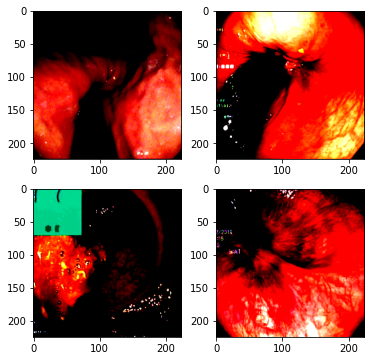

In [ ]:
plot_data_loader(train_loader, [2,2])

In [ ]:
from zmq.backend import device
def train_model(model, train_loader, val_loader, optimizer, lossFunc, epochs=6):
    start = time.time()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # device = torch.device("cpu")
    print("Device: {}".format(device))

    best_model_weights = model.state_dict()
    best_accuracy = 0

    train_accuracy_list = []
    val_accuracy_list = []

    for epoch in range(1,epochs+1):

      for i, train_batch in enumerate(train_loader):
        images, labels, model = train_batch[0].to(device), train_batch[1].to(device), model.to(device)

        outputs = model(images)
        loss = lossFunc(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()

        for j, val_batch in enumerate(val_loader):
          images_, labels_ = val_batch[0].to(device), val_batch[1].to(device)
          outputs_ = model(images_)
          loss_ = lossFunc(outputs_, labels_)
          total_ = labels_.size(0)
          _,predicted_ = torch.max(outputs_.data, 1)
          correct_ = (predicted_ == labels_).sum().item()

        train_loss = loss.item()
        train_accuracy = (correct / total) * 100
        train_accuracy_list.append(train_accuracy)
        val_loss = loss_.item()
        val_accuracy = (correct_ / total_) * 100
        val_accuracy_list.append(val_accuracy)

        if val_accuracy > best_accuracy:
          best_accuracy = val_accuracy
          best_model_weights = model.state_dict()

        print("Epoch [{}/{}], Train_Loss: {:.4f}, Train_Accuracy: {:.2f}%  Val_Loss: {:.4f}, Val_Accuracy: {:.2f}%"
                .format(epoch, epochs, train_loss, train_accuracy, val_loss, val_accuracy))
      # checkpoint_resNet = {
      # "model": resNet,
      # "train_accuracy_list": train_accuracy_list,
      # "val_accuracy_list": val_accuracy_list,
      # "state_dict": resNet.state_dict()
      # }

      # torch.save(checkpoint_resNet, "/content/drive/MyDrive/Colab Notebooks/AI_lab/AI Final Project/resNet50.pth")
    end = time.time()    
    print("######## Training Finished in {} seconds ###########".format(end-start))
    model.load_state_dict(best_model_weights)
    return model, best_model_weights, train_accuracy_list, val_accuracy_list

In [ ]:
# Model definition and initialization
model = resnet50()
num_ftrs = model.fc.in_features
path = "/content/drive/MyDrive/AI Final Project/23Class"
classes = os.listdir(path+"/")
model.fc = torch.nn.Linear(num_ftrs, 23)
optimizer = torch.optim.Adam(params=model.parameters())
loss_val = torch.nn.CrossEntropyLoss()

In [ ]:
resNet, best_model_dict, training_accuracy_list, val_accuracy_list = train_model(model, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, lossFunc=loss_val, epochs=6)

In [ ]:
resNet = {'model': resNet,
               'training_accuracy_list': training_accuracy_list,
               'val_accuracy_list': val_accuracy_list,
              'state_dict': resNet.state_dict()}

In [ ]:
torch.save(resNet, '/content/drive/MyDrive/AI Final Project/resNet_tl_23.pth')

In [ ]:
def train_val_comparison(train_accuracy_list, val_accuracy_list, loader_length):
    x = np.linspace(0, 20, num=234*20)
    plt.figure(figsize=(15,5))
    plt.plot(x, train_accuracy_list, label="Train")
    plt.plot(x, val_accuracy_list, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Train vs Validation")
    plt.legend()

In [ ]:
def train_val_comparison(train_accuracy_list, val_accuracy_list, loader_length):
    x = np.linspace(0, 6, num=234*6)
    plt.figure(figsize=(15,5))
    plt.plot(x, train_accuracy_list, label="Train")
    plt.plot(x, val_accuracy_list, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Train vs Validation")
    plt.legend()

In [ ]:
vgg16 = torchvision.models.vgg16(pretrained=False)
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, 23)]) # Add our layer with 4 outputs
vgg16.classifier = nn.Sequential(*features)
optimizer = torch.optim.SGD(params=vgg16.parameters(), lr=0.001,momentum=0.9)
loss = torch.nn.CrossEntropyLoss()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
vgg16, best_model_weights, training_accuracy_list, val_accuracy_list = train_model(vgg16, train_loader, val_loader, optimizer, loss, epochs=6)

Device: cuda:0
Epoch [1/6], Train_Loss: 3.1260, Train_Accuracy: 3.12%  Val_Loss: 3.1145, Val_Accuracy: 0.00%
Epoch [1/6], Train_Loss: 3.1310, Train_Accuracy: 0.00%  Val_Loss: 3.1283, Val_Accuracy: 10.00%
Epoch [1/6], Train_Loss: 3.1345, Train_Accuracy: 0.00%  Val_Loss: 3.1065, Val_Accuracy: 0.00%
Epoch [1/6], Train_Loss: 3.0991, Train_Accuracy: 12.50%  Val_Loss: 3.1013, Val_Accuracy: 0.00%
Epoch [1/6], Train_Loss: 3.1232, Train_Accuracy: 3.12%  Val_Loss: 3.0915, Val_Accuracy: 20.00%
Epoch [1/6], Train_Loss: 3.1099, Train_Accuracy: 9.38%  Val_Loss: 3.1566, Val_Accuracy: 0.00%
Epoch [1/6], Train_Loss: 3.1170, Train_Accuracy: 12.50%  Val_Loss: 3.0922, Val_Accuracy: 20.00%
Epoch [1/6], Train_Loss: 3.1205, Train_Accuracy: 3.12%  Val_Loss: 3.0741, Val_Accuracy: 10.00%
Epoch [1/6], Train_Loss: 3.1090, Train_Accuracy: 12.50%  Val_Loss: 3.0717, Val_Accuracy: 10.00%
Epoch [1/6], Train_Loss: 3.1111, Train_Accuracy: 3.12%  Val_Loss: 3.1456, Val_Accuracy: 0.00%
Epoch [1/6], Train_Loss: 3.0580, Trai

In [ ]:
vgg16 = {'model': vgg16,
               'training_accuracy_list': training_accuracy_list,
               'val_accuracy_list': val_accuracy_list,
              'state_dict': vgg16.state_dict()}

In [ ]:
torch.save(vgg16, '/content/drive/MyDrive/AI Final Project/vgg_23.pth')

In [ ]:
def train_val_comparison(train_accuracy_list, val_accuracy_list, loader_length):
    x = np.linspace(0, 6, num=6)
    plt.figure(figsize=(15,5))
    plt.plot(x, train_accuracy_list, label="Train")
    plt.plot(x, val_accuracy_list, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Train vs Validation")
    plt.legend()

In [ ]:
def accuracyForEachEpoch(accuracy_list):
    accuracy = []
    sum = 0
    for i, v in enumerate(accuracy_list):

        if((i+1)%234==0):
            accuracy.append(sum/234)
            sum = 0
        else: 
            sum += v

    return accuracy

In [ ]:
train_accuracy, val_accuracy = accuracyForEachEpoch(training_accuracy_list), accuracyForEachEpoch(val_accuracy_list)

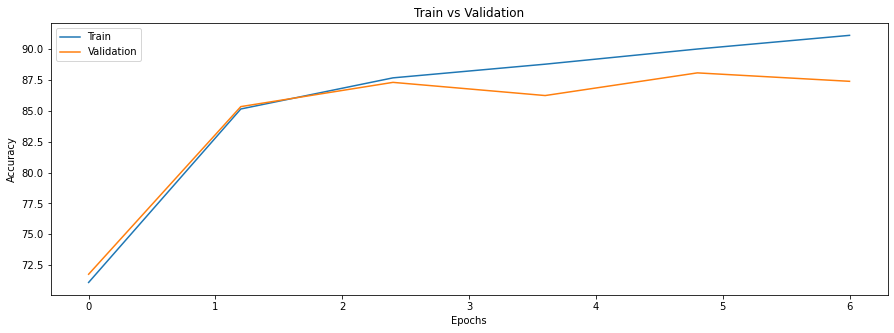

In [ ]:
train_val_comparison(train_accuracy, val_accuracy, len(train_loader))

In [ ]:
def evaluate_accuracy(model, test_loader):
  model.eval() 
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model2 = model.to(device)
  with torch.no_grad(): 
      correct = 0
      total = 0
      for data in test_loader:
          images, labels = data[0].to(device), data[1].to(device)
          outputs = model2(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
      print('Test Accuracy of the model on the {} test images: {} %'
          .format(total, (correct / total) * 100))
      
  return total, (correct / total) * 100

In [ ]:
total, accuracy = evaluate_accuracy(vgg16['model'], test_loader)

Test Accuracy of the model on the 2133 test images: 87.52930145335208 %
